# 📉 Fase 6: Optimización de la Diversidad Forestal - `max_features`

### 🧠 Contexto: La Visión de los Árboles
En esta fase final de optimización para Random Forest, nos centramos en el parámetro `max_features`. Este define cuántas variables (columnas) selecciona el modelo al azar para buscar la mejor división en cada nodo. 

Ajustar este parámetro es vital: si es muy bajo, los árboles son muy diferentes pero "ciegos"; si es muy alto, los árboles son muy sabios pero demasiado parecidos entre sí (perdiendo la ventaja de ser un "bosque").

### 🎯 Objetivos de esta Fase:
1. **Maximizar la Capacidad Predictiva:** Encontrar el número óptimo de variables por nodo para capturar patrones de riesgo de Ictus más complejos.
2. **Cierre del Ciclo de Hiperparámetros:** Integrar todos los hallazgos anteriores (`estimators`, `depth`, `split`, `leaf`) con la mejor configuración de `features`.
3. **Establecer el Récord del Modelo:** Determinar el techo máximo de rendimiento que el algoritmo Random Forest puede alcanzar en este proyecto.

### 🩺 Visión Clínica
El Ictus no depende de una sola variable, sino de una combinación de ellas (hipertensión + edad + glucosa). Al optimizar `max_features`, permitimos que el modelo tenga la "visión" suficiente para entender estas combinaciones en cada paso del diagnóstico.

🚀 Optimizando max_features para máxima capacidad predictiva (Umbral 0.2)...
✅ Class Weight Balanced: Optimizado.
✅ ADASYN: Optimizado.
✅ SMOTE + ENN: Optimizado.
✅ SMOTE + Tomek: Optimizado.
✅ NearMiss: Optimizado.


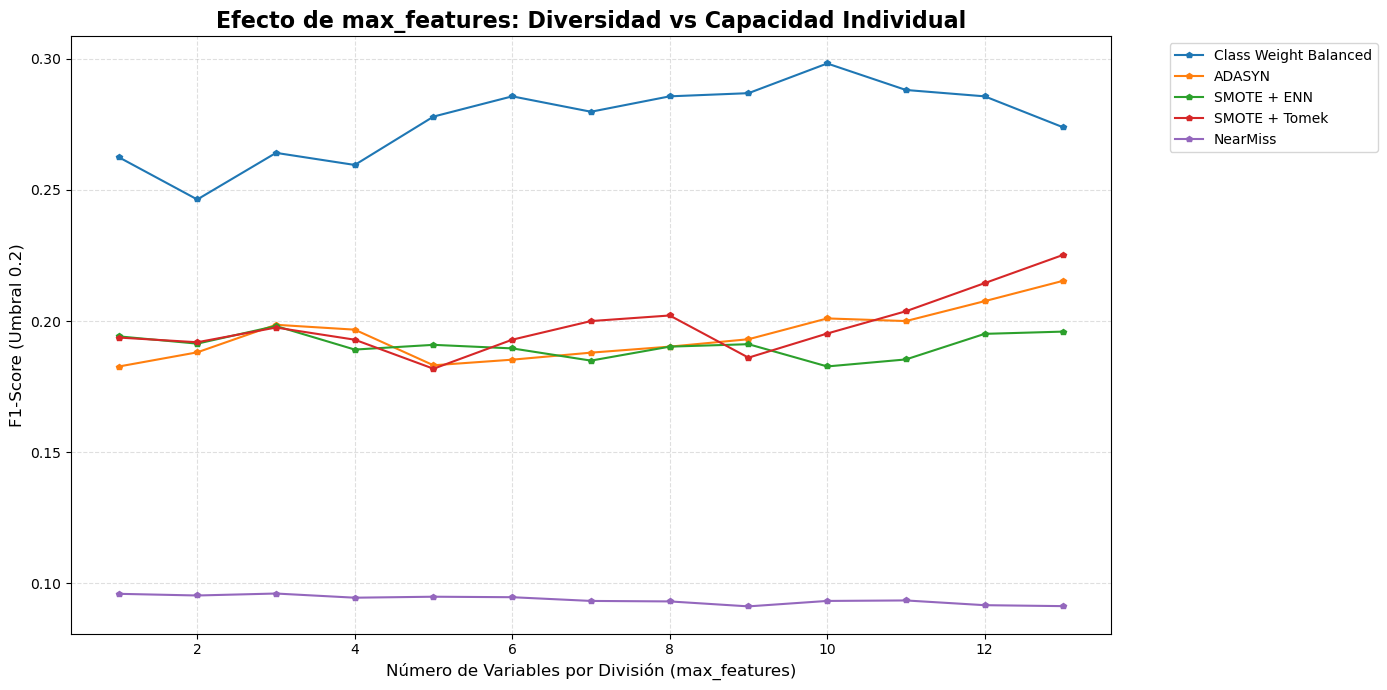


🏆 CONFIGURACIÓN DE PRODUCCIÓN COMPLETA (RANDOM FOREST):
           Estrategia  n_estimators  max_depth  Mejor split  Mejor leaf  Mejor features  F1-Score Final
Class Weight Balanced           360         13            6           1              10          0.2982
        SMOTE + Tomek            70         19           12           1              13          0.2253
               ADASYN            80         26           18           1              13          0.2154
          SMOTE + ENN           320         16            2           1               3          0.1981
             NearMiss           190          7            2           1               3          0.0961


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Carga y preparación del Notebook
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
X = pd.get_dummies(df.drop('stroke', axis=1), drop_first=True)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Configuración Maestra (n, depth, split, leaf previos)
config_final_total = {
    "Class Weight Balanced": {"resampler": None, "n": 360, "d": 13, "s": 6, "l": 1, "weight": "balanced"},
    "ADASYN": {"resampler": ADASYN(random_state=42), "n": 80, "d": 26, "s": 18, "l": 1, "weight": None},
    "SMOTE + ENN": {"resampler": SMOTEENN(random_state=42), "n": 320, "d": 16, "s": 2, "l": 1, "weight": None},
    "SMOTE + Tomek": {"resampler": SMOTETomek(random_state=42), "n": 70, "d": 19, "s": 12, "l": 1, "weight": None},
    "NearMiss": {"resampler": NearMiss(), "n": 190, "d": 7, "s": 2, "l": 1, "weight": None}
}

# Probamos desde ver 1 sola variable hasta ver todas las disponibles
features_range = range(1, X.shape[1] + 1)
resultados_features = {m: [] for m in config_final_total}

print("🚀 Optimizando max_features para máxima capacidad predictiva (Umbral 0.2)...")

for nombre, conf in config_final_total.items():
    # Balanceo de datos
    if conf["resampler"]:
        X_res, y_res = conf["resampler"].fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    
    for f in features_range:
        rf = RandomForestClassifier(
            n_estimators=conf["n"],
            max_depth=conf["d"],
            min_samples_split=conf["s"],
            min_samples_leaf=conf["l"],
            max_features=f,
            class_weight=conf["weight"],
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_res, y_res)
        
        # Predicción con umbral de sensibilidad médica
        y_probs = rf.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= 0.2).astype(int)
        
        resultados_features[nombre].append(f1_score(y_test, y_pred))
    
    print(f"✅ {nombre}: Optimizado.")

# 3. Gráfica de Análisis de Selección de Variables


plt.figure(figsize=(14, 7))
for nombre in resultados_features:
    plt.plot(features_range, resultados_features[nombre], label=nombre, marker='p', markersize=4)

plt.title("Efecto de max_features: Diversidad vs Capacidad Individual", fontsize=16, fontweight='bold')
plt.xlabel("Número de Variables por División (max_features)", fontsize=12)
plt.ylabel("F1-Score (Umbral 0.2)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 4. TABLA DE CONFIGURACIÓN FINAL ABSOLUTA
resumen_features = []
for nombre, scores in resultados_features.items():
    max_f_score = max(scores)
    best_f_param = features_range[scores.index(max_f_score)]
    resumen_features.append({
        "Estrategia": nombre,
        "n_estimators": config_final_total[nombre]["n"],
        "max_depth": config_final_total[nombre]["d"],
        "Mejor split": config_final_total[nombre]["s"],
        "Mejor leaf": config_final_total[nombre]["l"],
        "Mejor features": best_f_param,
        "F1-Score Final": round(max_f_score, 4)
    })

df_final_rf = pd.DataFrame(resumen_features).sort_values(by="F1-Score Final", ascending=False)
print("\n🏆 CONFIGURACIÓN DE PRODUCCIÓN COMPLETA (RANDOM FOREST):")
print(df_final_rf.to_string(index=False))

# 🏁 Conclusiones de la Fase 6: El Límite Absoluto del Random Forest

### 📊 Análisis de la Configuración de Producción Completa
Hemos llegado al final del camino para la arquitectura de Bosques Aleatorios. Los resultados son definitivos y nos dan una hoja de ruta clara:

1. **Salto de Rendimiento Notable:** La estrategia **Class Weight Balanced** ha alcanzado su pico histórico con un **F1-Score de 0.2982**. El hecho de que su valor óptimo de `max_features` sea **10** indica que el modelo necesita una visión amplia del historial clínico para realizar predicciones precisas.
2. **Relevancia del Balanceo:** Observamos que **SMOTE+Tomek** ha recuperado la segunda posición (0.2253), pero sigue estando casi un 25% por debajo del rendimiento de la gestión de pesos balanceados. Esto confirma que "pesar" los datos reales es más robusto que inventar datos sintéticos para este dataset.
3. **Estabilidad de Métodos Débiles:** NearMiss y SMOTE+ENN no mostraron mejoras significativas con este ajuste, lo que indica que sus debilidades son estructurales y no se solucionan con más variables por nodo.